In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..") # Adds higher directory to python modules path.

print(f"Current working dir is {os.getcwd()}")

from utils import *
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [15, 7]

Current working dir is /home/jma/Python3.7/Cubist_2021_11/dataset_process


In [2]:
# settings
data_root = '/home/jma/Python3.7/Cubist_2021_11'
dtcol = 'data_date'
seccol = 'security_id'

ds_id = 10

assert ds_id in [10, 11], "This script is only used to proprocess ds 10 and 11"

ds_filename = f'data_set_{ds_id}.csv'
scorecol = f'd{ds_id}'

In [3]:
df = preprocess_dataset_from_one_to_seven(data_root, ds_id, dtcol=dtcol, seccol=seccol)

Getting data from file 'data_set_10.csv' for score 'd10'.

df.head():
     data_date security_id    d10
158 2010-01-04     1000201   13.0
118 2010-01-04     1004801  800.0
879 2010-01-04     1009601   16.0
525 2010-01-04    10154401  115.0
169 2010-01-04     1017601  103.0

df.tail():
         data_date security_id      d10
3278831 2017-12-29       97801     49.0
3279859 2017-12-29      985601  27614.0
3280894 2017-12-29     9931801    264.0
3279132 2017-12-29      993201    125.0
3279017 2017-12-29      996501   1590.0

getting df shape of (3281273, 3)

No duplicates dtcol-seccol pairs is found.

shape of df (3281273, 3).

data_date      datetime64[ns]
security_id            object
d10                   float64
dtype: object


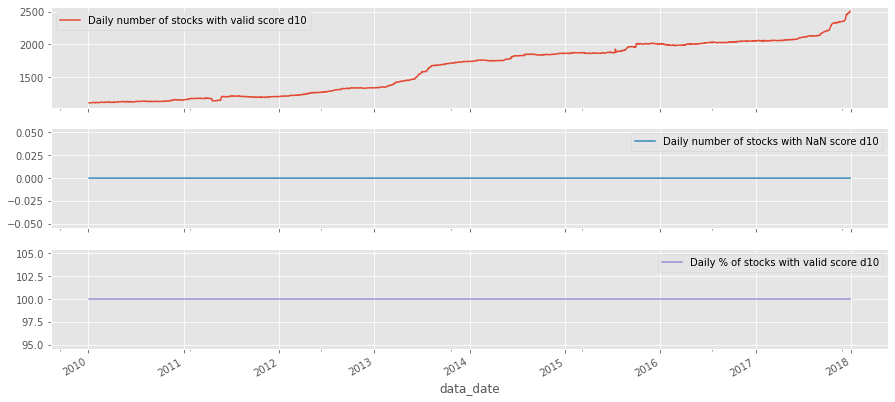

In [4]:
# plot the daily stock counts
plot_daily_stock_count(df, scorecol, dtcol=dtcol)

In [5]:
## Since 0 normally carries useless information in this type of sparse dataset, thus we replace 0 with NaN and drop them 
df = replace_zero_and_drop_nan(df, scorecol)

Since 0 values normally carry useless information in type of sparse dataset, thus we replace 0 with NaN and drop them
NaNs count for each column:
data_date         0
security_id       0
d10            1168
dtype: int64
Dropping all NaNs
descriptive stats for df is:
                d10
count  3.280105e+06
mean   5.168321e+02
std    2.632066e+03
min    1.000000e+00
25%    1.500000e+01
50%    5.900000e+01
75%    2.080000e+02
max    1.558570e+05


In [7]:
print("Loading the generated research universe")
rsch_universe = pd.read_csv(os.path.join(data_root, 'new_processed_csvs/new_rsch_universe.csv.gz'), compression='gzip',
                            usecols=[dtcol, seccol],
                            parse_dates=[dtcol], dtype={seccol: str})

print("Merging the dataset with research universe\n")
data = pd.merge(df, rsch_universe, on=[dtcol, seccol], how='inner')
print("Counting NaNs for each column\n", data.isnull().sum())

Loading the generated research universe
Merging the dataset with research universe

Counting NaNs for each column
 data_date      0
security_id    0
d10            0
dtype: int64


In [8]:
data.groupby(dtcol).size().plot(title=f'Daily {scorecol} #stocks falling into the trading universe')

<AxesSubplot:title={'center':'Daily d10 #stocks falling into the trading universe'}, xlabel='data_date'>

In [ ]:
save_file_path = os.path.join(data_root, f'new_processed_csvs/new_data_{ds_id}.csv.gz')
print(f"data is saved to {save_file_path}")
data.to_csv(save_file_path, index=False, compression='gzip')

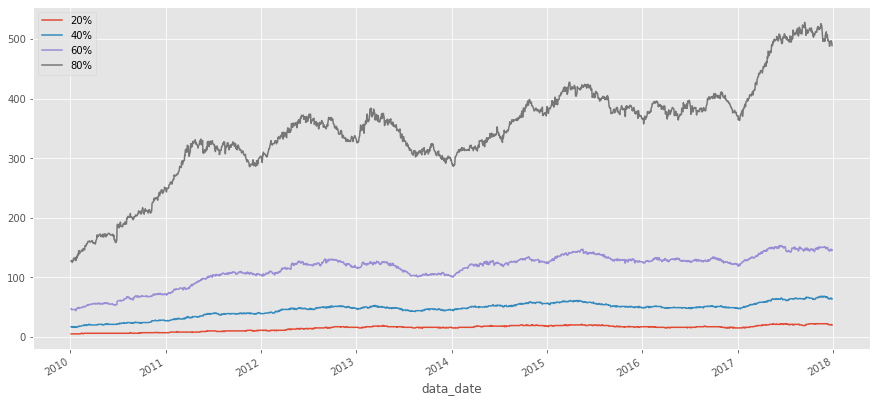

In [9]:
plot_timeseries_dist(data, scorecol, dtcol, plot_min_max=False)

In [ ]:
ts_series = data.groupby(dtcol)[scorecol].apply(
    lambda x: pd.Series([x.min(), x.quantile(0.2), x.quantile(0.4), x.quantile(0.6), x.quantile(0.8), x.max()],
                         index=['Min', '20%', '40%', '60%', '80%', 'Max']))
ts_series = ts_series.unstack().reset_index()

In [ ]:
yr = '2017'
ts_series.loc[ts_series[dtcol].between(f'{yr}-01-01', f'{yr}-12-30')].set_index(dtcol).plot()

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os

# settings
data_root = '/home/jma/Python3.7/Cubist_2021_11'

# d1 has strong seasonal pattern, from Min, Max time series plot
# d11 may be something to do with market cap

def plot_timeseries_dist(df, scorecol, dtcol, plot_min_max=False):
    
    if plot_min_max:
        ts_series = df.groupby(dtcol)[scorecol].apply(
            lambda x: pd.Series(
                [x.min(), x.quantile(0.2), x.quantile(0.4), x.quantile(0.6), x.quantile(0.8), x.max()],
                 index=['Min', '20%', '40%', '60%', '80%', 'Max']))
    else:
        ts_series = df.groupby(dtcol)[scorecol].apply(
            lambda x: pd.Series(
                [x.quantile(0.2), x.quantile(0.4), x.quantile(0.6), x.quantile(0.8)],
                 index=['20%', '40%', '60%', '80%']))
    ts_series.unstack().plot()

In [ ]:
ds_id = 10
csvfile = f'data_set_{ds_id}.csv'
scorecol = f'd{ds_id}'
dtcol = 'data_date'
seccol = 'security_id'

with zipfile.ZipFile(os.path.join(data_root, 'data_sets.zip')) as zf:
    df = pd.read_csv(zf.open(csvfile), parse_dates=['data_date'], dtype={'security_id': str})
    df[scorecol] = pd.to_numeric(df[scorecol], errors='coerce')
    df.sort_values(by=['data_date', 'security_id'], inplace=True)

In [ ]:
print(df.duplicated(subset=[dtcol, seccol]).sum())
print(df.shape)

In [ ]:
# df[scorecol] = df[scorecol].replace([0, np.inf, -np.inf], np.nan)
print(df[scorecol].describe())
print(df.head(), '\n\n')
print(df.tail(), '\n\n')
print(df.shape, '\n\n')
print(df.dtypes, '\n\n')
print(df.isnull().sum(), '\n\n')

In [ ]:
print("Before dropping 0, shape: ", df.shape)
df[scorecol] = df[scorecol].replace([0, np.inf, -np.inf], np.nan)
df.dropna(subset=[scorecol], inplace=True)
print("After dropping 0, shape: ", df.shape)
df.groupby(dtcol).size().plot()

In [ ]:
df[scorecol].describe()

In [ ]:
rsch_universe = pd.read_csv('/home/jma/Python3.7/Cubist_2021_11/rsch_universe.csv.gz', 
                            usecols=['data_date', 'security_id'], 
                            parse_dates=['data_date'], dtype={'security_id': str})

data = df.merge(rsch_universe, on=['data_date', 'security_id'], how='inner')
print(data.head())

In [ ]:
ts_series = data.groupby(dtcol)[scorecol].apply(
    lambda x: pd.Series([x.min(), x.quantile(0.2), x.quantile(0.4), x.quantile(0.6), x.quantile(0.8), x.max()],
                         index=['Min', '20%', '40%', '60%', '80%', 'Max']))
ts_series = ts_series.unstack().reset_index()

In [ ]:
yr = '2017'
ts_series.loc[ts_series[dtcol].between(f'{yr}-01-01', f'{yr}-12-30')].set_index(dtcol).plot()

In [ ]:
plot_timeseries_dist(data, scorecol, dtcol=dtcol, plot_min_max=False)

In [ ]:
data.groupby("data_date").size().plot()

In [ ]:
data.to_csv(os.path.join(data_root, 'data_10.csv.gz'), index=False, compression='gzip')